<a href="https://colab.research.google.com/github/alexander-toschev/cv-course/blob/main/FD_SIFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

They are rotation-invariant, which means, even if the image is rotated, we can find the same corners. It is obvious because corners remain corners in rotated image also. But what about scaling? A corner may not be a corner if the image is scaled. For example, check a simple image below. A corner in a small image within a small window is flat when it is zoomed in the same window. So Harris corner is not scale invariant.

In this image we can see that 1 large corner become as 3 small ones.

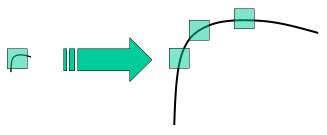

## Scale-space Extrema Detection
From the image above, it is obvious that we can’t use the same window to detect keypoints with different scale. It is OK with small corner. But to detect larger corners we need larger windows. For this, scale-space filtering is used. In it, Laplacian of Gaussian is found for the image with various $\sigma$ values. LoG acts as a blob detector which detects blobs in various sizes due to change in $\sigma$. In short, $\sigma$ acts as a scaling parameter. For eg, in the above image, gaussian kernel with low $\sigma$ gives high value for small corner while guassian kernel with high $\sigma$ fits well for larger corner. So, we can find the local maxima across the scale and space which gives us a list of $(x,y,\sigma)$ values which means there is a potential keypoint at $(x,y)$ at $\sigma$ scale.

But this LoG is a little costly, so SIFT algorithm uses Difference of Gaussians which is an approximation of LoG. Difference of Gaussian is obtained as the difference of Gaussian blurring of an image with two different $\sigma$, let it be $\sigma$ and $k\sigma$. This process is done for different octaves of the image in Gaussian Pyramid. 

![image](https://github.com/alexander-toschev/cv-course/raw/main/data/sift_dog.jpg)

Once this DoG are found, images are searched for local extrema over scale and space. For eg, one pixel in an image is compared with its 8 neighbours as well as 9 pixels in next scale and 9 pixels in previous scales. If it is a local extrema, it is a potential keypoint. It basically means that keypoint is best represented in that scale. It is shown in below image:


![image](https://github.com/alexander-toschev/cv-course/raw/main/data/sift_local_extrema.jpg)


Regarding different parameters, the paper gives some empirical data which can be summarized as, number of octaves = 4, number of scale levels = 5, initial $\sigma=1.6, k=\sqrt{2}$ etc as optimal values.

## 2. Keypoint Localization
Once potential keypoints locations are found, they have to be refined to get more accurate results. They used Taylor series expansion of scale space to get more accurate location of extrema, and if the intensity at this extrema is less than a threshold value (0.03 as per the paper), it is rejected. This threshold is called contrastThreshold in OpenCV

DoG has higher response for edges, so edges also need to be removed. For this, a concept similar to Harris corner detector is used. They used a 2x2 Hessian matrix (H) to compute the pricipal curvature. We know from Harris corner detector that for edges, one eigen value is larger than the other. So here they used a simple function,

If this ratio is greater than a threshold, called edgeThreshold in OpenCV, that keypoint is discarded. It is given as 10 in paper.

So it eliminates any low-contrast keypoints and edge keypoints and what remains is strong interest points.

## 3. Orientation Assignment
Now an orientation is assigned to each keypoint to achieve invariance to image rotation. A neigbourhood is taken around the keypoint location depending on the scale, and the gradient magnitude and direction is calculated in that region. An orientation histogram with 36 bins covering 360 degrees is created. (It is weighted by gradient magnitude and gaussian-weighted circular window with \sigma equal to 1.5 times the scale of keypoint. The highest peak in the histogram is taken and any peak above 80% of it is also considered to calculate the orientation. It creates keypoints with same location and scale, but different directions. It contribute to stability of matching.

## 4. Keypoint Descriptor
Now keypoint descriptor is created. A 16x16 neighbourhood around the keypoint is taken. It is devided into 16 sub-blocks of 4x4 size. For each sub-block, 8 bin orientation histogram is created. So a total of 128 bin values are available. It is represented as a vector to form keypoint descriptor. In addition to this, several measures are taken to achieve robustness against illumination changes, rotation etc.

## 5. Keypoint Matching
Keypoints between two images are matched by identifying their nearest neighbours. But in some cases, the second closest-match may be very near to the first. It may happen due to noise or some other reasons. In that case, ratio of closest-distance to second-closest distance is taken. If it is greater than 0.8, they are rejected. It eliminaters around 90% of false matches while discards only 5% correct matches, as per the paper.

So this is a summary of SIFT algorithm. For more details and understanding, reading the original paper is highly recommended. Remember one thing, this algorithm is patented. So this algorithm is included in Non-free module in OpenCV.

So now let’s see SIFT functionalities available in OpenCV. Let’s start with keypoint detection and draw them. First we have to construct a SIFT object. We can pass different parameters to it which are optional and they are well explained in docs.
sift.detect() function finds the keypoint in the images. You can pass a mask if you want to search only a part of image. Each keypoint is a special structure which has many attributes like its (x,y) coordinates, size of the meaningful neighbourhood, angle which specifies its orientation, response that specifies strength of keypoints etc.

OpenCV also provides cv2.drawKeyPoints() function which draws the small circles on the locations of keypoints. If you pass a flag, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS to it, it will draw a circle with size of keypoint and it will even show its orientation. See below example.

In [1]:
!wget https://w7.pngwing.com/pngs/710/895/png-transparent-chessboard-mathematics-board-game-chess-game-symmetry-black.png
!pip install opencv-contrib-python==4.4.0.44

import numpy as np
import cv2
import sys
import dlib
from PIL import Image
import cv2
import dlib
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt


--2021-10-24 17:38:03--  https://w7.pngwing.com/pngs/710/895/png-transparent-chessboard-mathematics-board-game-chess-game-symmetry-black.png
Resolving w7.pngwing.com (w7.pngwing.com)... 104.21.16.171, 172.67.214.225, 2606:4700:3035::6815:10ab, ...
Connecting to w7.pngwing.com (w7.pngwing.com)|104.21.16.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2370 (2.3K) [image/png]
Saving to: ‘png-transparent-chessboard-mathematics-board-game-chess-game-symmetry-black.png.3’

png-transparent-che 100%[===================>]   2.31K  --.-KB/s    in 0s      

2021-10-24 17:38:03 (28.6 MB/s) - ‘png-transparent-chessboard-mathematics-board-game-chess-game-symmetry-black.png.3’ saved [2370/2370]



4.4.0


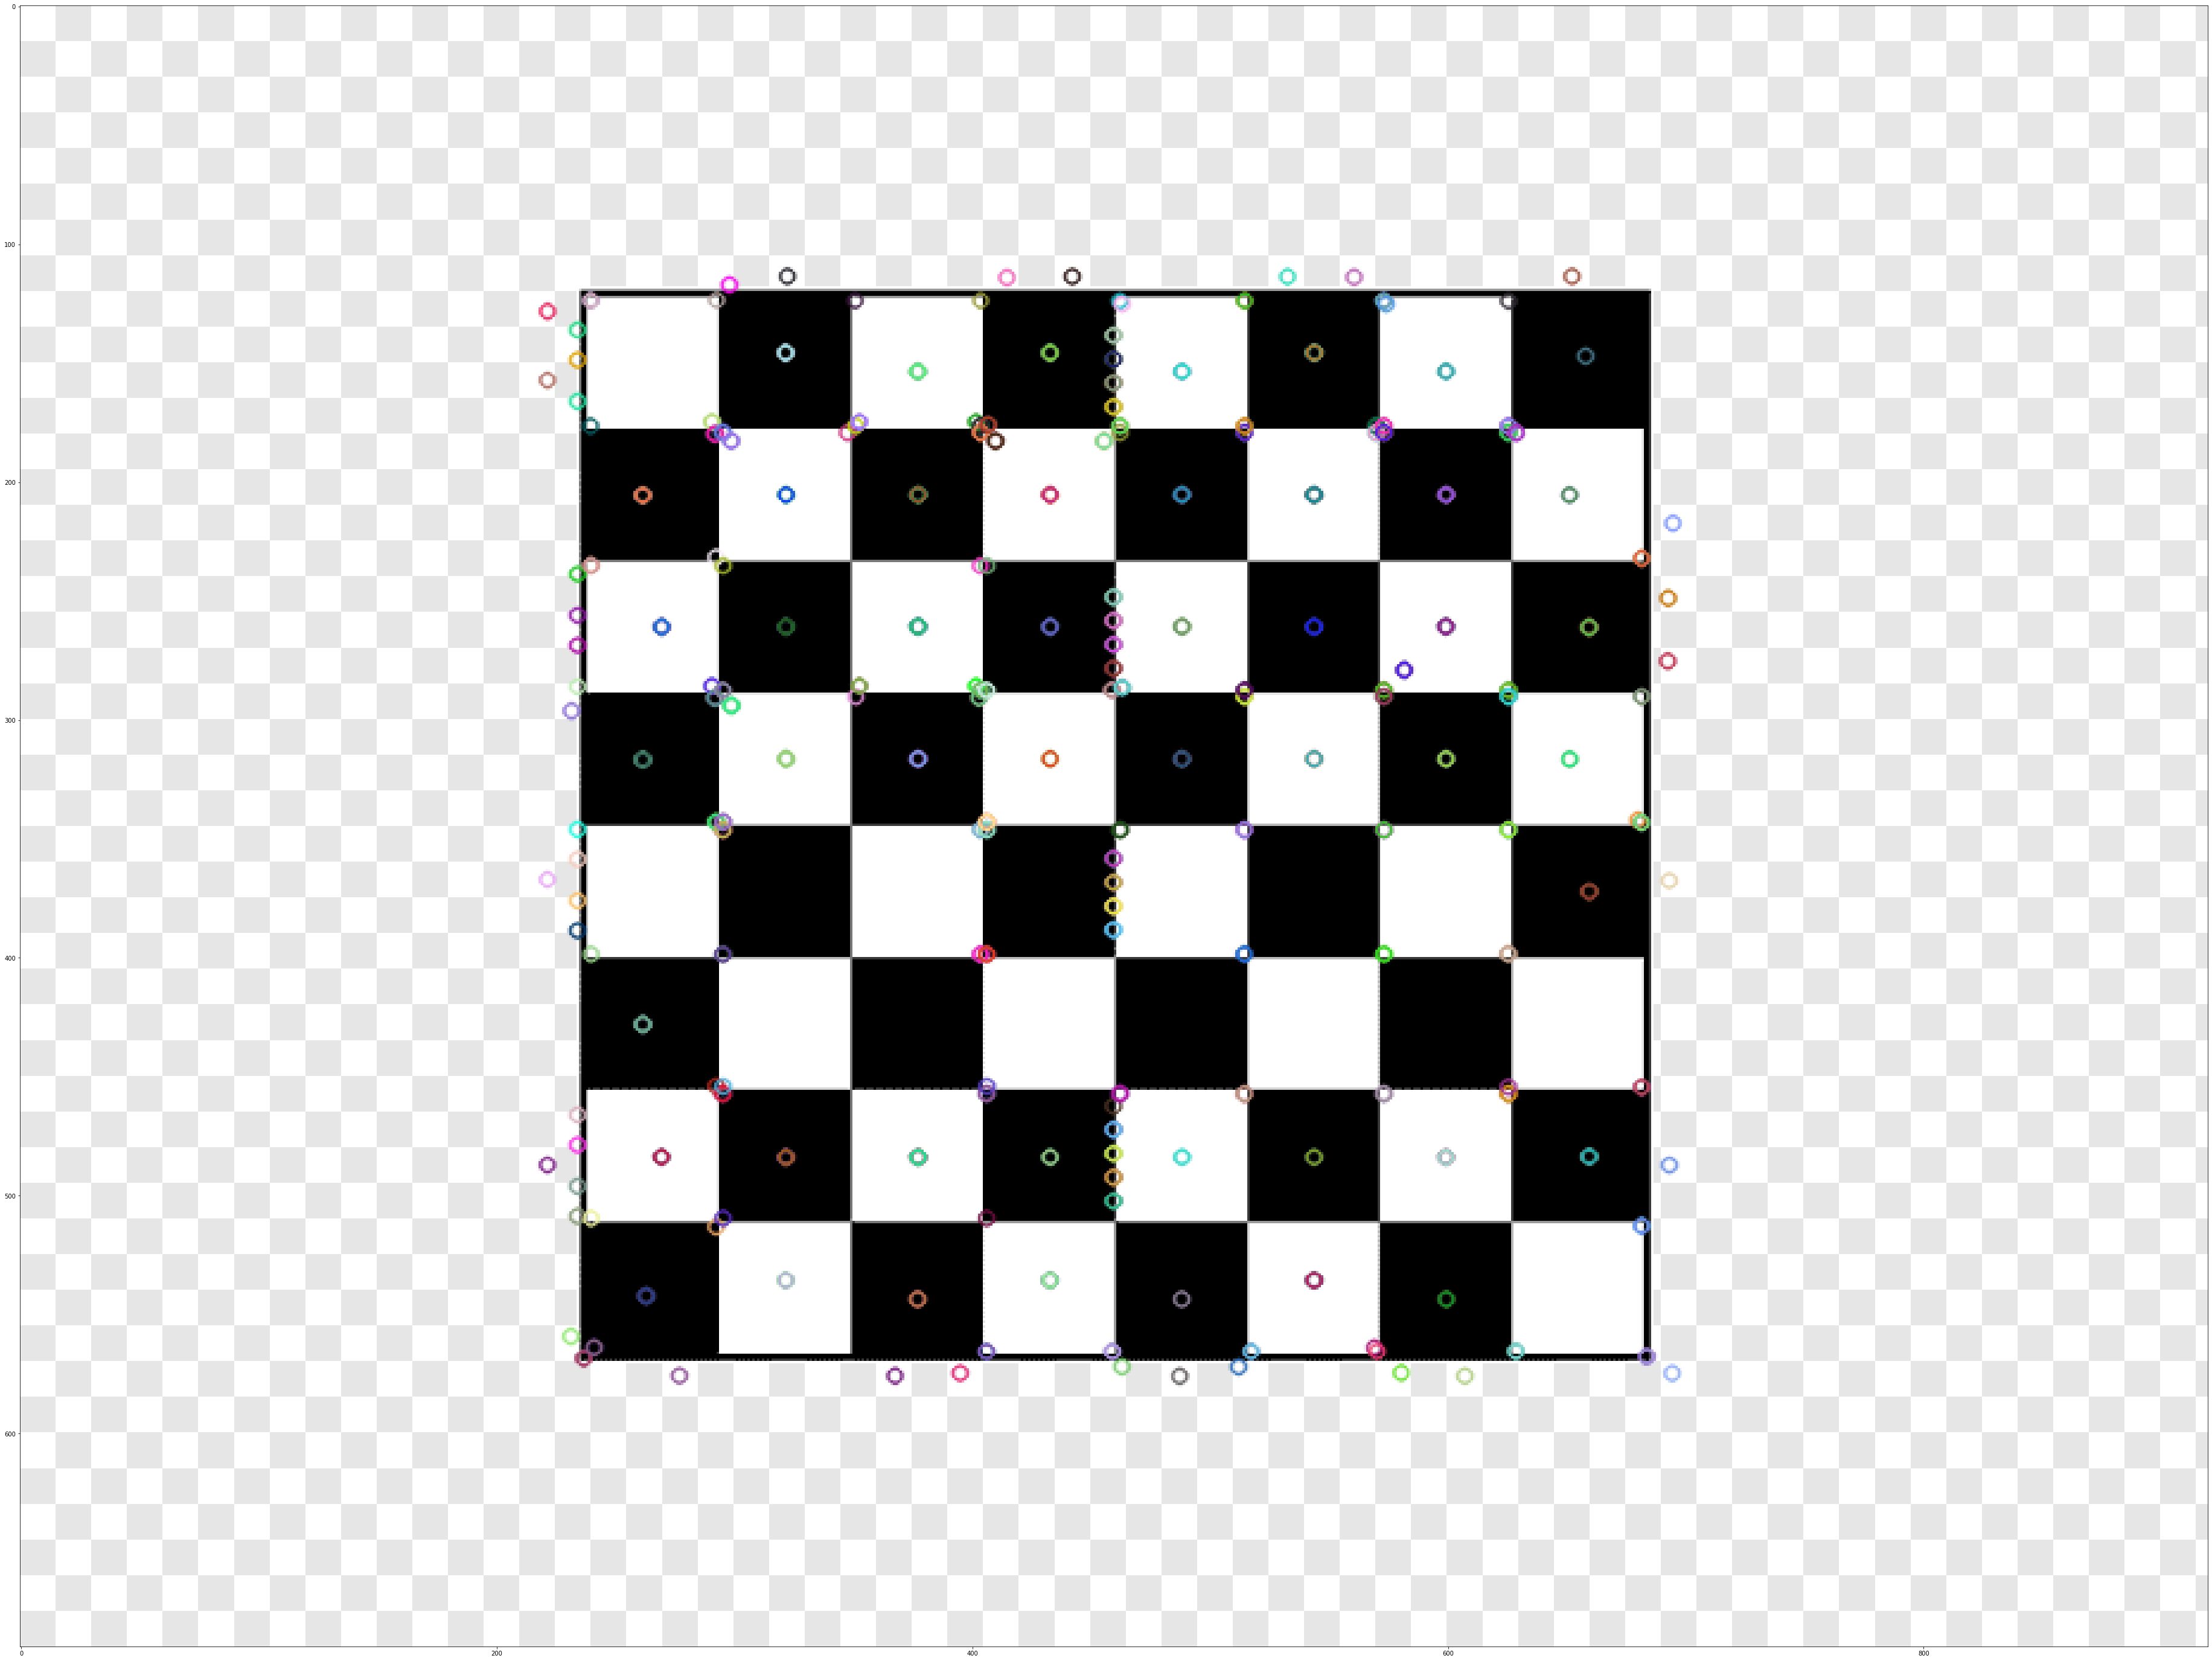

In [3]:
plt.rcParams['figure.figsize'] = [100, 50]
filename = '/content/png-transparent-chessboard-mathematics-board-game-chess-game-symmetry-black.png'
img = cv2.imread(filename)
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print (cv2.__version__)
sift = cv2.SIFT_create()
kp = sift.detect(gray,None)

img=cv2.drawKeypoints(gray,kp, img)


plt.imshow(img)
plt.show()